> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [noshowappointments-kagglev2-may-2016.csv]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 


### Question(s) for Analysis
>**Tip**: Clearly state one or more questions that you plan on exploring over the course of the report. You will address these questions in the **data analysis** and **conclusion** sections. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> **Tip**: Once you start coding, use NumPy arrays, Pandas Series, and DataFrames where appropriate rather than Python lists and dictionaries. Also, **use good coding practices**, such as, define and use functions to avoid repetitive code. Use appropriate comments within the code cells, explanation in the mark-down cells, and meaningful variable names. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

the first step in our process is to load and handling the data

### General Properties


In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df= pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
#showing the shape of the data

df.shape


(110527, 14)

In [6]:
#inspecting for duplicated data

df.duplicated().sum()


0

In [7]:
#check if there is unique values

df['PatientId'].nunique()

62299

In [8]:
#inspecting for duplicated data in patientid column

df['PatientId'].duplicated().sum()

48228

In [9]:
#inspecting for duplicated data in patientid column and noshow

df.duplicated(['PatientId','No-show']).sum()


38710

In [10]:
#verifiying from true values and missing values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [11]:
#information about data
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [12]:
#check the row index of -1 in age column
miss=df.query('Age=="-1"')
miss

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No



### Data Cleaning
now, we have found some of false data and its time to deal with it to obtain a clear information 

In [13]:
#clearing the -1 value of age column
df.drop(index=99832,inplace=True)

In [14]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172536e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.438963e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [15]:
#editing names of columns
df.rename(columns={'Hipertension':'Hypertension'},inplace=True)
df.rename(columns={'No-show':'No_show'},inplace=True)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [16]:
#removing duplicated ids with duplicating showing case
df.drop_duplicates(['PatientId','No_show'],inplace=True)
df.shape

(71816, 14)

In [17]:
#removing useless data

df.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay'],axis=1,inplace=True)

df.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='eda'></a>
## Exploratory Data Analysis

after we have cleaned our data we are diving into do some descriptive statistics to show 
the relationship between variables and visualize them


### Research Question 1 (is there a relationship between the Age an the attendence ?)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97f3fa1dd8>,
      dtype=object)

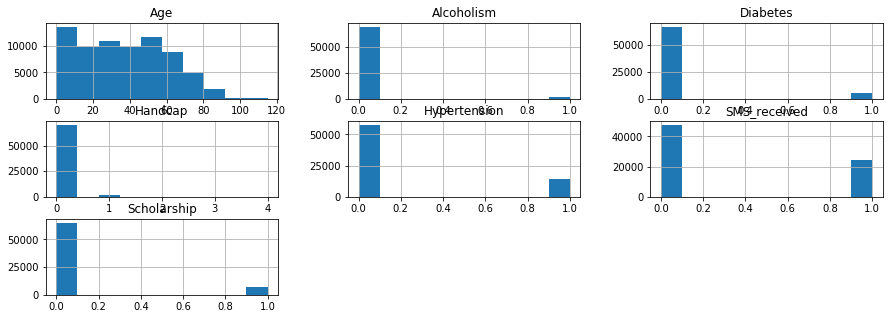

In [18]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
df.hist(figsize=(15,5))

In [19]:
#spliting the patients into two groups
show=df.No_show=='No'
no_show=df.No_show=='Yes'
df[show].count(),df[no_show].count()

(Gender           54153
 Age              54153
 Neighbourhood    54153
 Scholarship      54153
 Hypertension     54153
 Diabetes         54153
 Alcoholism       54153
 Handcap          54153
 SMS_received     54153
 No_show          54153
 dtype: int64, Gender           17663
 Age              17663
 Neighbourhood    17663
 Scholarship      17663
 Hypertension     17663
 Diabetes         17663
 Alcoholism       17663
 Handcap          17663
 SMS_received     17663
 No_show          17663
 dtype: int64)

In [20]:
# the average of two groups
df[show].mean(),df[no_show].mean()

(Age             37.229166
 Scholarship      0.091334
 Hypertension     0.202944
 Diabetes         0.072868
 Alcoholism       0.023600
 Handcap          0.020904
 SMS_received     0.297232
 dtype: float64, Age             34.376267
 Scholarship      0.108419
 Hypertension     0.170922
 Diabetes         0.065108
 Alcoholism       0.029440
 Handcap          0.017777
 SMS_received     0.453094
 dtype: float64)

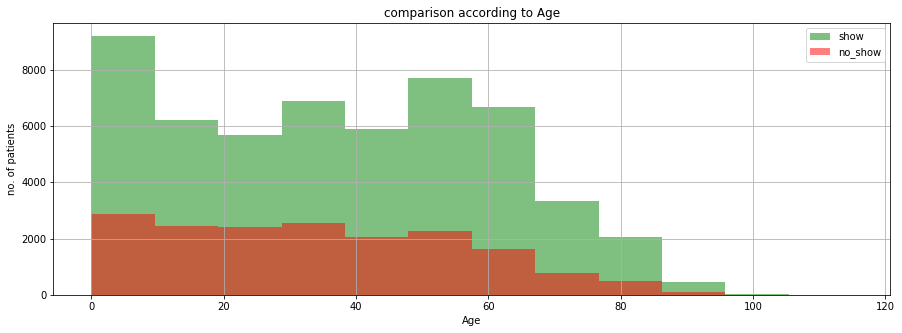

In [21]:
# do you think that the age affects the attendence ?
def attendence(df,col_name,attended,absent):
    
    plt.figure(figsize=[15,5])
    df[col_name][show].hist(alpha=0.5,bins=12,color='green',label='show')
    df[col_name][no_show].hist(alpha=0.5,bins=12,color='red',label='no_show')
    plt.legend();
    plt.title('comparison according to Age')
    plt.xlabel('Age')
    plt.ylabel('no. of patients');
attendence(df,'Age',show,no_show)

### Research Question 2  (is there a relationship between the Age an chronic disease ?)

Text(0,0.5,'mean age')

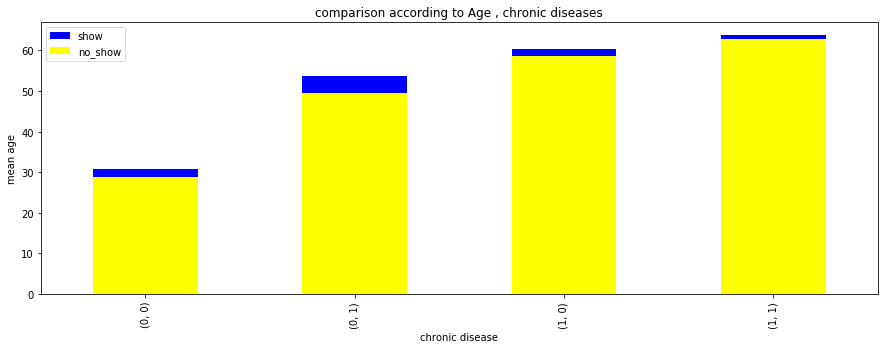

In [25]:
#do you think that chronic disease affects the attendence together ?
plt.figure(figsize=[15,5])
df[show].groupby(['Hypertension','Diabetes']).mean()['Age'].plot(kind='bar',color='blue',label='show')
df[no_show].groupby(['Hypertension','Diabetes']).mean()['Age'].plot(kind='bar',color='yellow',label='no_show')
plt.title('comparison according to Age , chronic diseases')
plt.legend();
plt.xlabel('chronic disease')
plt.ylabel('mean age')



In [26]:
df[show].groupby(['Hypertension','Diabetes']).mean()['Age'],df[no_show].groupby(['Hypertension','Diabetes']).mean()['Age']

(Hypertension  Diabetes
 0             0           30.713360
               1           53.701370
 1             0           60.270517
               1           63.764303
 Name: Age, dtype: float64, Hypertension  Diabetes
 0             0           28.768691
               1           49.481172
 1             0           58.650380
               1           62.913282
 Name: Age, dtype: float64)

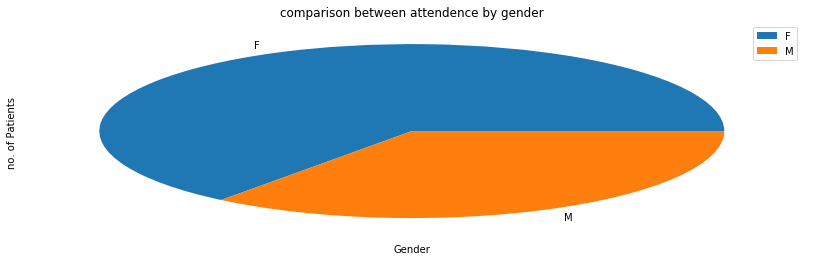

In [28]:
def attendence(df,col_name,attended,absent):
    plt.figure(figsize=[14,4])
    df[col_name][show].value_counts(normalize=True).plot(kind='pie',label='show')
    plt.legend();
    plt.title('comparison between attendence by gender')
    plt.xlabel('Gender')
    plt.ylabel('no. of Patients ');
attendence(df,'Gender',show,no_show)

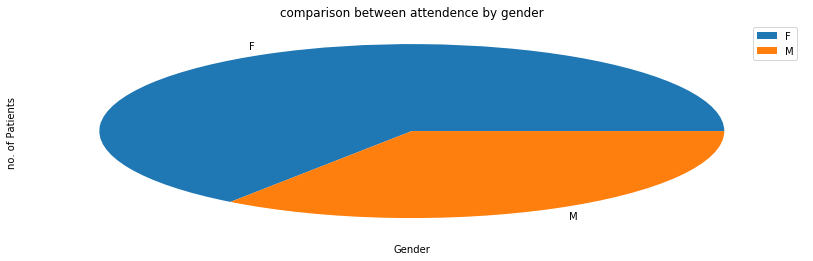

In [29]:
def attendence(df,col_name,attended,absent):
    plt.figure(figsize=[14,4])
    df[col_name][no_show].value_counts(normalize=True).plot(kind='pie',label='show')
    plt.legend();
    plt.title('comparison between attendence by gender')
    plt.xlabel('Gender')
    plt.ylabel('no. of Patients ');
attendence(df,'Gender',show,no_show)

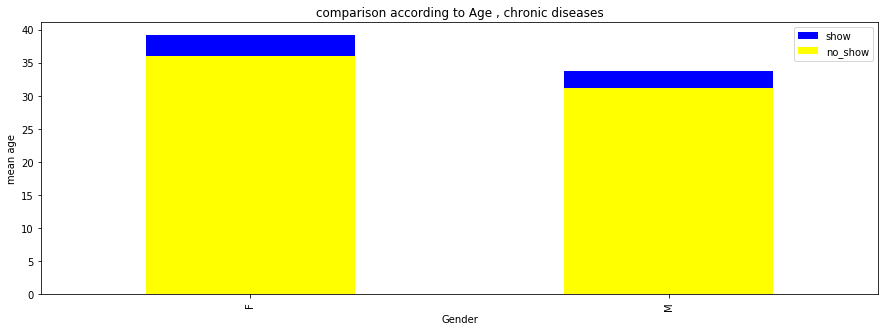

In [31]:
#do you think that chronic diseas affects the attendence together
plt.figure(figsize=[15,5])
df[show].groupby('Gender').Age.mean().plot(kind='bar',color='blue',label='show')
df[no_show].groupby('Gender').Age.mean().plot(kind='bar',color='yellow',label='no_show')
plt.title('comparison according to Age , chronic diseases')
plt.legend();
plt.xlabel('Gender')
plt.ylabel('mean age');

In [32]:
print(df[show].groupby('Gender').Age.mean(),df[no_show].groupby('Gender').Age.mean(),
      df[show].groupby('Gender').Age.median(),df[no_show].groupby('Gender').Age.median())

Gender
F    39.130292
M    33.766269
Name: Age, dtype: float64 Gender
F    36.06501
M    31.22040
Name: Age, dtype: float64 Gender
F    39
M    32
Name: Age, dtype: int64 Gender
F    34
M    29
Name: Age, dtype: int64


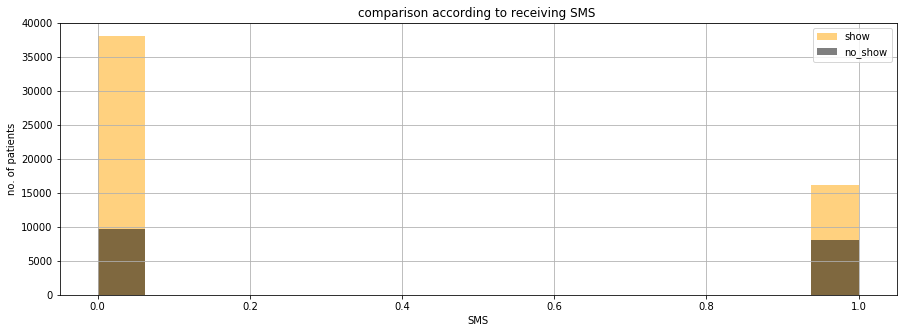

In [33]:
#do you think that receiving SMS affects the attendence
def attendence(df,col_name,attended,absent):
    
    plt.figure(figsize=[15,5])
    df[col_name][show].hist(alpha=0.5,bins=16,color='orange',label='show')
    df[col_name][no_show].hist(alpha=0.5,bins=16,color='black',label='no_show')
    plt.legend();
    plt.title('comparison according to receiving SMS ')
    plt.xlabel('SMS')
    plt.ylabel('no. of patients');
attendence(df,'SMS_received',show,no_show)

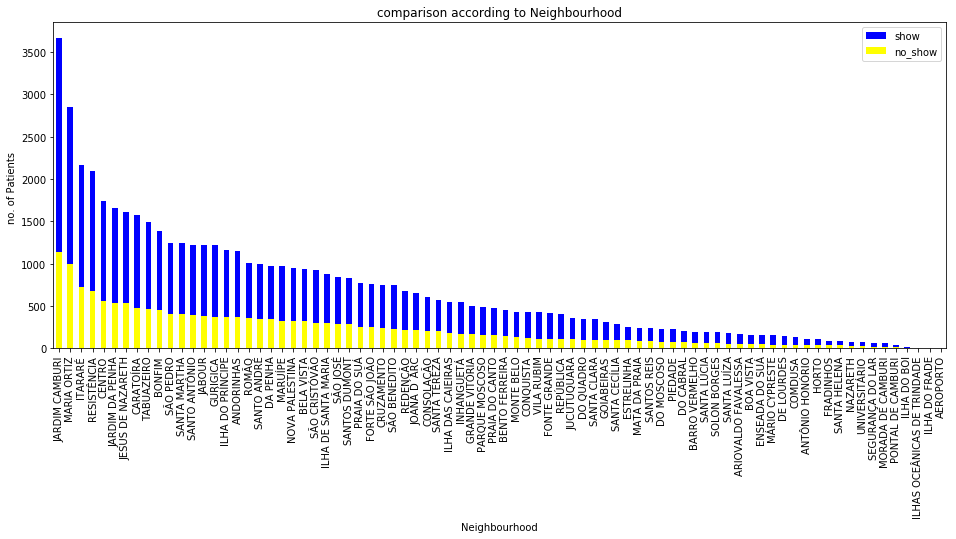

In [37]:
#do you think that neighbourhood affects the attendence
plt.figure(figsize=[16,6])
df.Neighbourhood[show].value_counts().plot(kind='bar',color='blue',label='show')
df.Neighbourhood[no_show].value_counts().plot(kind='bar',color='yellow',label='no_show')
plt.legend();
plt.title('comparison according to Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('no. of Patients ');

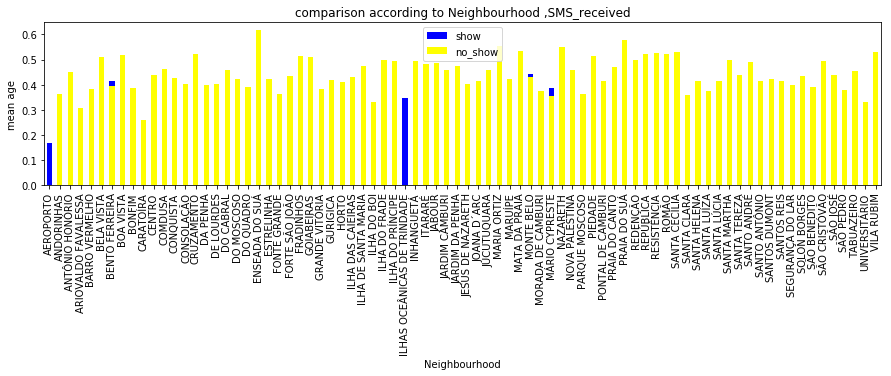

In [38]:
#do you think that receiving SMS differs from Neighbourhood to another?
plt.figure(figsize=[15,3])
df[show].groupby('Neighbourhood').SMS_received.mean().plot(kind='bar',color='blue',label='show')
df[no_show].groupby('Neighbourhood').SMS_received.mean().plot(kind='bar',color='yellow',label='no_show')
plt.title('comparison according to Neighbourhood ,SMS_received')
plt.legend();
plt.xlabel('Neighbourhood')
plt.ylabel('mean age');

<a id='conclusions'></a>
## Conclusions
neighbourhood affects the attendence extremely, we notice that JARDIM CAMBURI has the greatest no. of patients 
and greatest rate

receiving sms affecting the no. of showing patients from neighbourhood to another

Age affects the showing rate obviously 
Ages from 0:8 are the most showing patients take care of their kids than from 45:55 
and Ages above 65 are the least attending

showing patients who received sms are less than who did not receive  



## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [39]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0